<h2 align = "center">Kaggle Invasive Species Monitoring </h2>
<div align = "center"><b>Author:</b> Ishwar M<br /><b>Date:</b> 30th May, 2017</div>

#### Design of learning algorithm:

- First stage utilizes a pre-trained VGG net from the ImageNet challenge. Only the convolutional layers are used from the VGG net
- Second stage is a regression head consisting of 2 layer FCN. FCN has 400 units and finally only one output denoting the probability of the species being invasive is extracted

In [1]:
from PIL import Image as img
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import pickle as pk
import time
import pandas as pd
%matplotlib inline

#### Fitting image to 224x224 for VGG nets

In [2]:
# train_images = np.empty(dtype='uint8',shape = [0,224,224,3])
# for i in range(2295):
#     if((i+1) % 500 == 0):
#         print (i+1)
#     im = img.open('/home/ishwar/workspace/Data/Invasive Species Monitoring/train/' + str(i + 1) + '.jpg')
#     im = im.resize(size=(224,224))
#     train_images = np.append(train_images,[np.asarray(im)],axis=0)
#     im = None
# pk.dump(train_images,open( "train_resize", "wb" ))

In [3]:
# Loading pickled image data. Preprocessing using the code above
fo = open("/home/ishwar/workspace/notebooks/train_resize","rb")
train_images = pk.load(file=fo)

In [4]:
# Convert from RGB to 0-1
train_images = train_images/255.

In [5]:
# Import labels for train
train_labels = np.loadtxt(fname='/home/ishwar/workspace/Data/Invasive Species Monitoring/train_labels.csv',
                          delimiter=",", skiprows = 1)
train_labels = np.array(train_labels[:,1]).reshape(2295,1)

Global constants. Initial plan is to train only the FC layers. Initial attempt with LEARN_RATE = 1e-5 for 500 iterations provided 91% accuracy

In [6]:
# Global constants
NUM_ITERATIONS = 1000
BATCH_SIZE = 10
LEARN_RATE = 1e-5
INPUT_LENGTH = len(train_images)
STEP_ERROR = 50
LAMBDA_REG = 1e-5

In [7]:
# Start an interactive session
sess = tf.InteractiveSession()

In [8]:
# Convolution with same padding
def conv2d(x,W):
    return(tf.nn.conv2d(x,W,strides = [1,1,1,1],padding='SAME'))

# 2x2 pooling
def max_pool2d(x):

    return(tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME'))

In [9]:
# Initializer functions for weight and bias
def weight_initialization(shape):
    initial = tf.random_normal(shape=shape, stddev=0.01) * 2/np.sqrt(shape[0] * shape[1])
    return(tf.Variable(initial))

def bias_variable(shape):
    initial = tf.constant(shape=shape,value= 0.1)
    return(tf.Variable(initial))

In [10]:
# Loading ImageNet weights for VGG16 network
netWeights = np.load(file='/home/ishwar/workspace/Data/Invasive Species Monitoring/vgg16_weights.npz')

In [11]:
print netWeights.keys()

['conv4_3_W', 'conv5_1_b', 'conv1_2_b', 'conv5_2_b', 'conv1_1_W', 'conv5_3_b', 'conv5_2_W', 'conv5_3_W', 'conv1_1_b', 'fc7_b', 'conv5_1_W', 'conv1_2_W', 'conv3_2_W', 'conv4_2_b', 'conv4_1_b', 'conv3_3_W', 'conv2_1_b', 'conv3_1_b', 'conv2_2_W', 'fc6_b', 'fc8_b', 'conv4_3_b', 'conv2_2_b', 'fc6_W', 'fc8_W', 'fc7_W', 'conv3_2_b', 'conv4_2_W', 'conv3_3_b', 'conv3_1_W', 'conv2_1_W', 'conv4_1_W']


In [12]:
# Passing the training images through the VGG network
# initialize the Image array and output class variable
x = tf.placeholder(tf.float32,shape = [None,224,224,3])
y = tf.placeholder(tf.float32,shape = [None,1])

In [13]:
# Using VGG network, Initializing weights from the dictionary object imported
# Declared as constants since VGG need not be retrained

# Layer 1
W1_1 = tf.constant(netWeights["conv1_1_W"])
b1_1 = tf.constant(netWeights["conv1_1_b"])

W1_2 = tf.constant(netWeights["conv1_2_W"])
b1_2 = tf.constant(netWeights["conv1_2_b"])

# Layer 2
W2_1 = tf.constant(netWeights["conv2_1_W"])
b2_1 = tf.constant(netWeights["conv2_1_b"])

W2_2 = tf.constant(netWeights["conv2_2_W"])
b2_2 = tf.constant(netWeights["conv2_2_b"])

# Layer 3
W3_1 = tf.constant(netWeights["conv3_1_W"])
b3_1 = tf.constant(netWeights["conv3_1_b"])

W3_2 = tf.constant(netWeights["conv3_2_W"])
b3_2 = tf.constant(netWeights["conv3_2_b"])

W3_3 = tf.constant(netWeights["conv3_3_W"])
b3_3 = tf.constant(netWeights["conv3_3_b"])

# Layer 4
W4_1 = tf.constant(netWeights["conv4_1_W"])
b4_1 = tf.constant(netWeights["conv4_1_b"])

W4_2 = tf.constant(netWeights["conv4_2_W"])
b4_2 = tf.constant(netWeights["conv4_2_b"])

W4_3 = tf.constant(netWeights["conv4_3_W"])
b4_3 = tf.constant(netWeights["conv4_3_b"])

# Layer 5
W5_1 = tf.constant(netWeights["conv5_1_W"])
b5_1 = tf.constant(netWeights["conv5_1_b"])

W5_2 = tf.constant(netWeights["conv5_2_W"])
b5_2 = tf.constant(netWeights["conv5_2_b"])

W5_3 = tf.constant(netWeights["conv5_3_W"])
b5_3 = tf.constant(netWeights["conv5_3_b"])

In [14]:
# FC Layers to be trained

# 1st FC layer
W6_1 = weight_initialization(shape=[25088,400])
b6_1 = bias_variable(shape=[400])

# 2nd FC layer
W6_2 = weight_initialization(shape=[400,400])
b6_2 = bias_variable(shape=[400])

# Finaly layer to extract probabilites
W6_3 = weight_initialization(shape=[400,1])
b6_3 = bias_variable(shape=[1])

In [15]:
# VGG network operations

# Convolution layer 1 has 2 filters with 3x3 convolutions of depth 64

# W1_1 - [3,3,3,64]
# b1_1 - [64,]
h_conv1_1 = tf.nn.relu(conv2d(x, W1_1) + b1_1)

# W1_2 - [3,3,64,64]
# b1_2 - [64,]
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, W1_2) + b1_2)

# Pooling layer 1
h_pool1 = max_pool2d(h_conv1_2)

# Convolution layer 2. Has two convolution filters with size 3x3 and depth 128

# W2_1 - [3,3,64,128]
# b2_1 - [128,]
h_conv2_1 = tf.nn.relu(conv2d(h_pool1, W2_1) + b2_1)

# W2_2 - [3,3,128,128]
# b2_2 - [128,]
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, W2_2) + b2_2)

# Pooling layer 2
h_pool2 = max_pool2d(h_conv2_2)

# Convolution layer 3. Has 3 convolution filters of size 3x3 and depth 256

# W3_1 - [3,3,128,256]
# b3_1 - [256,]
h_conv3_1 = tf.nn.relu(conv2d(h_pool2, W3_1) + b3_1)

# W3_2 - [3,3,256,256]
# b3_2 - [256,]
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, W3_2) + b3_2)

# W3_3 - [3,3,256,256]
# b3_3 - [256,]
h_conv3_3 = tf.nn.relu(conv2d(h_conv3_2, W3_3) + b3_3)

# Pooling layer 3
h_pool3 = max_pool2d(h_conv3_3)

# Convolution layer 4. Has 3 convolution layers of size 3x3 and depth 512

# W4_1 - [3,3,256,512]
# b4_1 - [512,]
h_conv4_1 = tf.nn.relu(conv2d(h_pool3, W4_1) + b4_1)

# W4_2 - [3,3,512,512]
# b4_2 - [512,]
h_conv4_2 = tf.nn.relu(conv2d(h_conv4_1, W4_2) + b4_2)

# W4_3 - [3,3,512,512]
# b4_3 - [512,]
h_conv4_3 = tf.nn.relu(conv2d(h_conv4_2, W4_3) + b4_3)

# Pooling layer 4
h_pool4 = max_pool2d(h_conv4_3)

# Convolution layer 5. Has 3 convolution layers of size 3x3 and depth 512

# W5_1 - [3,3,512,512]
# b5_1 - [512,]
h_conv5_1 = tf.nn.relu(conv2d(h_pool4, W5_1) + b5_1)

# W5_2 - [3,3,512,512]
# b5_2 - [512,]
h_conv5_2 = tf.nn.relu(conv2d(h_conv5_1, W5_2) + b5_2)

# W5_1 - [3,3,512,512]
# b5_1 - [512,]
h_conv5_3 = tf.nn.relu(conv2d(h_conv5_2, W5_3) + b5_3)

# Pooling layer 4
h_pool5 = max_pool2d(h_conv5_3)

In [16]:
# Adding FC layers to the top. Reshape to fit FC layer
vgg_out = tf.reshape(h_pool5,shape=[-1, 7*7*512])

# FC Layer 1 (25088 x 4096)
h_fc6_1 = tf.nn.relu(tf.matmul(vgg_out, W6_1) + b6_1)

# Adding dropout
keep_prob = tf.placeholder(tf.float32)
h_fc6_1_drop = tf.nn.dropout(h_fc6_1, keep_prob)

# FC Layer 2 (4096 x 4096)
h_fc6_2 = tf.nn.relu(tf.matmul(h_fc6_1_drop, W6_2) + b6_2)
# Adding dropout
h_fc6_2_drop = tf.nn.dropout(h_fc6_2, keep_prob)

# Final Layer
y_out = tf.nn.relu(tf.matmul(h_fc6_2_drop, W6_3) + b6_3)

In [17]:
# Defining the loss function
loss = (y - y_out) ** 2
loss = tf.reduce_sum(loss)

In [18]:
W6_1_reg = tf.reduce_sum(W6_1 ** 2)
W6_2_reg = tf.reduce_sum(W6_2 ** 2)
W6_3_reg = tf.reduce_sum(W6_3 ** 2)
l2_reg = W6_1_reg + W6_2_reg + W6_3_reg

In [19]:
total_loss = loss + LAMBDA_REG * l2_reg

In [20]:
# Adam Optimizer with all default settings
optim = tf.train.AdamOptimizer(learning_rate=LEARN_RATE)
train_step = optim.minimize(total_loss)

In [21]:
sess.run(tf.global_variables_initializer())

In [ ]:
y_loss = np.empty(dtype = 'float16',shape = [0,1])

In [28]:
# Running the training algorithm with Adam optimization for the network
for i in range(200):
    
    # Mini batch selection
    batch = np.random.choice(range(INPUT_LENGTH),replace = False, size = BATCH_SIZE)
    batch_input = train_images[batch,:,:,:]
    batch_labels = train_labels[batch]
    
    if(i % STEP_ERROR == 0):
        
        train_loss = loss.eval(feed_dict={
            x:batch_input, y: batch_labels, keep_prob: 1})
        
        y_loss = np.append(y_loss,train_loss)
        
        reg_loss = l2_reg.eval()
        
        print("step %d, training loss %g Regularization loss %g"%(i, train_loss, reg_loss))
        
    train_step.run(feed_dict={x:batch_input, y:batch_labels, keep_prob:0.5})

step 0, training loss 1.05428 Regularization loss 19.8364
step 50, training loss 1.76958 Regularization loss 20.2991
step 100, training loss 0.725271 Regularization loss 20.7244
step 150, training loss 0.482401 Regularization loss 21.1119


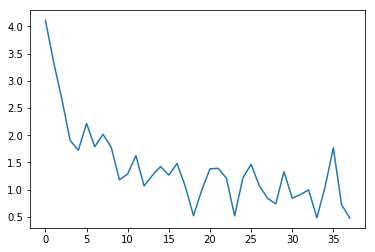

In [30]:
plt.plot(y_loss)
plt.show()

In [ ]:
# Loading and predicting on test data
# test_images = np.empty(dtype='uint8',shape = [0,224,224,3])
# for i in range(1531):
#     if((i+1) % 500 == 0):
#         print (i+1)
#     im = img.open('/home/ishwar/workspace/Data/Invasive Species Monitoring/test/' + str(i + 1) + '.jpg')
#     im = im.resize(size=(224,224))
#     test_images = np.append(test_images,[np.asarray(im)],axis=0)
#     im = None
# pk.dump(test_images,open( "test_resize", "wb" ))

In [31]:
# Loading pickled image data
fo = open("/home/ishwar/workspace/notebooks/test_resize","rb")
test_images = pk.load(file=fo)

In [32]:
test_images = test_images/255.

In [33]:
y_array = np.empty(dtype = 'float', shape = [0,1])

In [34]:
for i in range(153):
    
    if(i < 152):
        testIndex = range(i*10,i*10+10)
    else:
        testIndex = range(1520,1531)
    
    testImage = test_images[testIndex,:,:,:]
    
    if(i*10 % 100 == 0):
        print "%d images done"%(i*10)
    
    y_prob = y_out.eval(feed_dict = {x:testImage, keep_prob: 1.0})
    
    y_array = np.append(y_array, y_prob)

0 images done
100 images done
200 images done
300 images done
400 images done
500 images done
600 images done
700 images done
800 images done
900 images done
1000 images done
1100 images done
1200 images done
1300 images done
1400 images done
1500 images done


In [35]:
indices = range(1531)

In [36]:
indices = np.add(indices, 1).reshape(1531,)

In [37]:
final_out = np.append(indices.reshape(1531,1), y_array.reshape(1531,1), axis = 1)

In [ ]:
# np.savetxt(X=final_out,fname="/home/ishwar/workspace/Data/Invasive Species Monitoring/predictions.csv",
#            delimiter=",", header = "name,invasive", comments = '')

In [38]:
pdFrame = pd.DataFrame(data=final_out)

In [39]:
pdFrame.columns = ['name','invasive']

In [40]:
pdFrame[['name']] = pdFrame[['name']].astype('int32')

In [41]:
pdFrame.to_csv('/home/ishwar/workspace/Data/Invasive Species Monitoring/predictions.csv',index=False)